# Vision Transformer

- paper, [link](https://arxiv.org/abs/2010.11929)

In [2]:
!pip uninstall -y transformers tokenizers datasets accelerate evaluate
!pip install transformers==4.28.0 tokenizers==0.13.3 datasets==2.12.0 accelerate==0.19.0 evaluate==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 24.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.3 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 2.6 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 834.9 kB/s eta 0:00:00 MB/s eta 0:00:01
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/00/45/ec3407adf6f6b5bf867a4462b2b0af27597a26bd3cd6e2534cb6ab029938/filelock-3.12.2-py3-none-any.whl.metadata
  Using cached filelock-3.12.2-py3-none-any.whl.metadata (2.7 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.11.0 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Using cached huggingfac

In [3]:
from datasets import load_dataset

dataset_name = "beans"
dataset = load_dataset(dataset_name)
dataset

/home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Dataset beans downloaded and prepared to /home/apakiman/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 196.15it/s]


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

{'image_file_path': '/home/apakiman/.cache/huggingface/datasets/downloads/extracted/22ffcf1e27e229dfb149d4f5f44ca4a6895308cf2fe463633770406cf0f6aeaf/train/bean_rust/bean_rust_train.76.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7FE60041F6A0>, 'labels': 1}


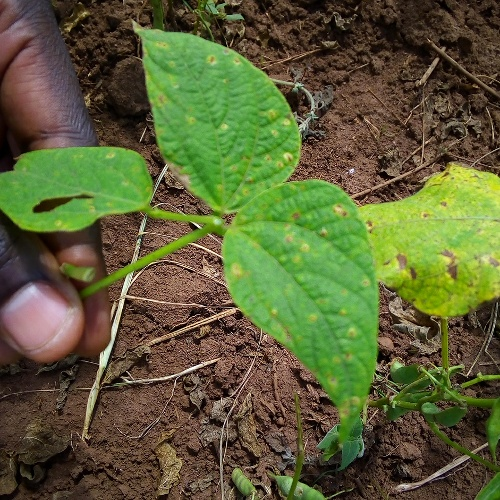

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)
bean_rust


In [4]:
from IPython.display import display

index = 667
example = dataset["train"][index]
print(example)

image = example["image"]
display(image)

labels = dataset["train"].features["labels"]
print(labels)

readable_label = labels.int2str(example["labels"])
print(readable_label)

In [5]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

2023-08-25 16:37:47.412919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 16:37:52.091687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [6]:
feature_extractor(image, return_tensors='pt')["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [7]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [8]:
dataset = load_dataset(dataset_name)
dataset = dataset["train"]
dataset = dataset.train_test_split(0.2)

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_dataset = dataset.with_transform(transform)
prepared_dataset

Found cached dataset beans (/home/apakiman/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 182.71it/s]


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

In [9]:
prepared_dataset["train"][0:2]

{'pixel_values': tensor([[[[-0.2549, -0.5451, -0.7176,  ...,  0.1451,  0.1059,  0.1608],
          [-0.2078, -0.4902, -0.6627,  ...,  0.2000,  0.2000,  0.2078],
          [-0.0353, -0.3725, -0.6000,  ...,  0.2000,  0.2000,  0.2157],
          ...,
          [-0.6471, -0.6471, -0.6392,  ..., -0.2078, -0.2471, -0.1922],
          [-0.6314, -0.6235, -0.6392,  ..., -0.4588, -0.4039, -0.3647],
          [-0.6235, -0.6235, -0.6157,  ..., -0.5137, -0.5137, -0.4902]],

         [[-0.3020, -0.5843, -0.7333,  ...,  0.0431,  0.0196,  0.0824],
          [-0.2706, -0.5373, -0.6941,  ...,  0.0980,  0.1059,  0.1216],
          [-0.1137, -0.4275, -0.6314,  ...,  0.0980,  0.0980,  0.1137],
          ...,
          [-0.6706, -0.6863, -0.6784,  ..., -0.2157, -0.2784, -0.2314],
          [-0.6392, -0.6471, -0.6706,  ..., -0.4039, -0.3647, -0.3333],
          [-0.6314, -0.6314, -0.6314,  ..., -0.4431, -0.4353, -0.4196]],

         [[-0.3412, -0.6000, -0.7333,  ..., -0.0275, -0.0510,  0.0118],
          [-0

In [11]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [12]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_604219/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['labels'].names
print(labels)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

['angular_leaf_spot', 'bean_rust', 'healthy']


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
number_of_layers = 0
for name, param in model.named_parameters():
    print(f"Layer: {name}, Frozen: {not param.requires_grad}")
    number_of_layers += 1
print(number_of_layers)

Layer: vit.embeddings.cls_token, Frozen: False
Layer: vit.embeddings.position_embeddings, Frozen: False
Layer: vit.embeddings.patch_embeddings.projection.weight, Frozen: False
Layer: vit.embeddings.patch_embeddings.projection.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.query.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.query.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.key.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.key.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.value.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.value.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.output.dense.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.output.dense.bias, Frozen: False
Layer: vit.encoder.layer.0.intermediate.dense.weight, Frozen: False
Layer: vit.encoder.layer.0.intermediate.dense.bias, Frozen: False
Layer: vit.encoder.layer.0.output.dens

In [15]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=64,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["test"],
    tokenizer=feature_extractor,
)


In [18]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/52 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_604219/883871373.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_604219/883871373.py'                        │
│                                                                                                  │
│ /home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/transformers/trainer.py │
│ :1662 in train                                                                                   │
│                                                                                                  │
│   1659 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1660 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1661 │   │   )                                                                                 │
│ ❱ 1662 │   │   return inner_training_loop(                                                       │
│   1663 │   │   │   args=args,                                                                    │
│   1664 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1665 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/transformers/trainer.py │
│ :1929 in _inner_training_loop                                                                    │
│                                                                                                  │
│   1926 │   │   │   │   │   with model.no_sync():                                                 │
│   1927 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1928 │   │   │   │   else:                                                                     │
│ ❱ 1929 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1930 │   │   │   │                                                                             │
│   1931 │   │   │   │   if (                                                                      │
│   1932 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/transformers/trainer.py │
│ :2699 in training_step                                                                           │
│                                                                                                  │
│   2696 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2697 │   │                                                                                     │
│   2698 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2699 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2700 │   │                                                                                     │
│   2701 │   │   if self.args.n_gpu > 1:                                                           │
│   2702 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/transformers/trainer.py │
│ :2731 in compute_loss                                      